# Boris 2 sentence converter

For the one who is going to run the code, i really recommend to first run the code with print() in some variables so you can have a deep understanding. <br><br>
Before running the code, please make sure that the necessary packages are installed in your Jupyter Notebook environment.


In [1]:
import pandas as pd
import os
from unidecode import unidecode
from collections import Counter
import copy
import seaborn as sns
import math
import numpy as np
import ast
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

## Data Transform

In [2]:
def dataTransform(seqfile, ethofile, category):
    '''
    input : the xlsx file containing the sequence extracted from Boris
    output : seqdf, focal, individual, output_name, output_index, ethodict
    seqfile = name of the boris file containing sequence
    ethofile = name of the file with unit code : unit name
    '''
    # Make sequence dataframe + pre-process
    seqdf = pd.read_excel(seqfile)
        
    # # Add $ in front of each meta-unit
    seqdf = seqdf.replace("end", "$ - end")
    seqdf = seqdf.replace("pause", "$ - pause")
    seqdf = seqdf.replace("Entre dans le champs de vision", "$ - Entre dans le champs de vision")
    seqdf = seqdf.replace("Sort du champs de vision", "$ - Sort du champs de vision")
    
    focal = seqfile.split("\\")[-1].split('_')[1].split('.')[0]
    partner = seqfile.split("\\")[-1].split('_')[1].split('.')[1]
    output_name = seqfile.split('\\')[-1][:-5]
    output_index = seqfile.split('\\')[-1].split('_')[0]
    
    # Make ethogram dataframe + pre-process
    ethodf = pd.read_excel(ethofile) # Behavior code	Behavior type Key	Behavioral category Modality
    ethodf = ethodf[["Behavior code", "Behavior type", "Key", "Behavioral category","Modality"]]


    # Build dictionary of {units : code name}
    ethodict = {}
    for index, row in ethodf.iterrows(): # ethodf -> ['Behavior code', 'Behavior type', 'Key']
        row = ethodf.iloc[index]
        if category  == "units":
            if row['Behavior code'] == 'end' or row['Behavior code'] == 'pause' or row['Behavior code'] == 'Entre dans le champs de vision' or row['Behavior code'] == 'Sort du champs de vision':
                key, behavior_code_key =  row['Key'], '$'
            else: key, behavior_code_key = row['Key'], row['Behavior code'][0] # Get key and first letter of behavior code
            code = key + behavior_code_key
        
        elif category != "units":
            code = row[category]

        unit = row['Behavior code']
        ethodict[unit] = code
        
    return seqdf, focal, partner, output_name, output_index, ethodict


## Sequence 

In [3]:
def boris2sentence(seqfile, ethofile, output_file, metaunits, category):
    '''
        input : the xlsx file containing the sequence extracted from Boris
        output : a csv file with the obtained sentences as lines (each unit is a cell)
        seqfile = name of the boris file containing sequence
        ethofile = name of the file with unit code : unit name
        output_file = name of the csv file which will contain the output sequence
    '''
    seqdf, focal, partner, output_name, output_index, ethodict = dataTransform(seqfile, ethofile, category)
    #build sequence list
    seqlist = []
    for index, row in seqdf.iterrows(): # seqdf -> ['Time', 'Subject', 'Behavior', 'Behavior type']
        row = seqdf.iloc[index] 

        if not row['Behavior type'] == 'STOP':
            unit = row['Behavior']
            if(metaunits):
                #added unidecode to ensure that encoding differences don't produce mismatch errors
                if unidecode(row['Subject']) == unidecode(focal) : loc = "f"
                elif unidecode(row['Subject']) == unidecode(partner) : loc = "p"
                else : loc = "error" #and print("Mismatch between subject name and focal / partner")
                seqlist.append((loc, ethodict[unit]))
            else:
                if (category == "units" and (ethodict[unit][-1] == '$')) or (ethodict[unit] == 'Meta'):
                    continue
                else:
                    #added unidecode to ensure that encoding differences don't produce mismatch errors
                    if unidecode(row['Subject']) == unidecode(focal) : loc = "f"
                    elif unidecode(row['Subject']) == unidecode(partner) : loc = "p"
                    else : loc = "error" #and print("Mismatch between subject name and focal / partner")
                    seqlist.append((loc, ethodict[unit]))

    #transform into csv
    seqlist.insert(0, output_name) 
    seqlist.insert(0, output_index)
    sentdf = pd.DataFrame([seqlist])
    #comment the following line for test run
    sentdf.to_csv(output_file, mode='a', index=False, header=not os.path.exists(output_file))
    #print(f"succesfull with file : {seqfile}")
    return(sentdf)

### Generate sequence csv file with all Sequences

In [76]:
# If you create a new Category remind to set it with the same name as the column name
# Ex: "Behavior code", "Behavior type", "Key", "Behavioral category", "Modality"

category = "Modality" # units or Modality


#### Metaunits

In [77]:
directory = r".\DATA\Merged Interactions" 
ethofile = r".\DATA\Ethogram_Baboons_2024.xlsx"

output_dir = "Outputs/"+ category
output_file = output_dir + "/meta_"+ category +"_sequence_csv.csv"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if os.path.exists(output_file):
    os.remove(output_file)
    
metaunits=True
for filename in os.listdir(directory):
    if not filename.startswith(".") :
        sentdf = boris2sentence(os.path.join(directory, filename), ethofile, output_file, metaunits, category)

#### No Metaunits

In [78]:
directory = r".\DATA\Merged Interactions" 
ethofile = r".\DATA\Ethogram_Baboons_2024.xlsx"

output_dir = "Outputs/"+ category
output_file = output_dir +"/no_meta_"+ category +"_sequence_csv.csv"
metaunits=False

if os.path.exists(output_file):
    os.remove(output_file)
for filename in os.listdir(directory):
    if not filename.startswith(".") :
        sentdf = boris2sentence(os.path.join(directory, filename), ethofile, output_file, metaunits, category)

In [79]:
csv_file_path = "Outputs/"+category+"/no_meta_"+ category +"_sequence_csv.csv"
excel_file_path = "Outputs/"+category+"/no_meta_"+ category +"_sequence_excel.xlsx"

max_columns = 0
with open(csv_file_path, 'r') as file:
    for line in file:
        num_columns = len(line.split(',"'))
        max_columns = max(max_columns, num_columns)
column_names = ['id', 'File name'] + [i for i in range(max_columns-1)]

sequence_df = pd.read_csv(csv_file_path, delimiter=",", names=column_names).drop(0)
sequence_df.to_excel(excel_file_path, index=False)

In [80]:
sequence_df.head(5)

,id,File name,0,1,2,3
1,1,01_Lomé.Nekketsu_23.01.23_matin_BI,"('p', 'B')","('p', 'T')","('f', 'T')",NaN
2,2,02_Lips.Pipo_25.01.23_matin_UNI,"('f', 'B')","('f', 'B')","('f', 'T')",NaN
3,3,03_Bobo.Mako_26.01.23_matin_UNI,"('p', 'L')","('p', 'B')","('p', 'T')","('f', 'B')"
4,4,04_Angèle.Violette_26.01.23_matin_UNI,"('f', 'B')","('f', 'L')","('f', 'T')","('f', 'T')"
5,5,05_Bobo.Muse_30.01.23_matin_UNI,"('p', 'L')","('p', 'T')","('p', 'T')",NaN


### Details

In [81]:
output_file = "Outputs/"+category+"/Sequence_Details.csv"
sequence_details_df = sequence_df.copy()

#### Focal and Partner column

In [82]:
focals = sequence_details_df['File name'].apply(lambda x: x.split("_")[1].split(".")[0])
partners = sequence_details_df['File name'].apply(lambda x: x.split("_")[1].split(".")[1])
sequence_details_df['Focal'] = focals
sequence_details_df['Partner'] = partners

#### Sequence length

In [83]:
sequence_details_df["Sequence Length"] = sequence_details_df.iloc[:, 2:].count(axis=1)
# if os.path.exists(output_file):
#     os.remove(output_file)
    
sequence_details_df['id'] = sequence_details_df['id'].astype(int)
sequence_details_df = sequence_details_df.sort_values(by='id')
# sequence_details_df.to_csv(output_file)
# sequence_details_df.head(5)

#### Length and Tokens

In [84]:
# output_length_tokens = "Outputs/Length_Tokens.xlsx"

len_list, len_focal_list, len_partner_list, token_focal_list, token_partner_list, token_both_list, token_all_list = [],[],[],[],[],[],[]

length_tokens_df = sequence_df.copy()

for id, row in length_tokens_df.iloc[:,:-1].iterrows() :
    # count = 0
    len_f, len_p, token_f, token_p, token_a, token_both = [], [], [], [], [], []
    
    for elem in row[2:] :
        if not pd.isna(elem): 
            # count+=1
            if elem.split("'")[3] not in token_both :
                token_both.append(elem.split("'")[3])
                
            if elem not in token_a: #.split("'")[3]
                token_a.append(elem)
            if elem.split("'")[1]=='f':
                len_f.append(elem)
                if elem.split("'")[3] not in token_f :
                    token_f.append(elem.split("'")[3])
            if elem.split("'")[1]=='p' :
                len_p.append(elem)
                if elem.split("'")[3] not in token_p :
                    token_p.append(elem.split("'")[3])
    #print(len(token_a), len(token_i), len(token_f))

    # len_list.append(count)
    len_focal_list.append(len(len_f))
    len_partner_list.append(len(len_p))
    token_all_list.append(len(token_a))
    token_both_list.append(len(token_both))
    token_focal_list.append(len(token_f))
    token_partner_list.append(len(token_p))

length_tokens_df["Focal Sequence Length"] = len_focal_list
length_tokens_df["Partner Sequence Length"] = len_partner_list
length_tokens_df["Number Total Tokens (repeated counted)"] = token_all_list
length_tokens_df["Number Focal Tokens"] = token_focal_list
length_tokens_df["Number Partner Tokens"] = token_partner_list
length_tokens_df["Number Both Tokens (repeated NOT counted)"] = token_both_list

# if os.path.exists(output_length_tokens):
#     os.remove(output_length_tokens)

# length_tokens_df['id'] = length_tokens_df['id'].astype(int)
# length_tokens_df = length_tokens_df.sort_values(by='id')
    
# length_tokens_df.to_csv(output_length_tokens)
# length_tokens_df.head()

## Overlap and Actions

#### Overlap

In [85]:
def boris2sentence_overlap(seqfile, ethofile, output_file, category) :
    #print(f"processing file : {seqfile}")
    '''
        input : the xlsx file containing the sequence extracted from Boris
        output : a csv file with the obtained sentences as lines (each unit is a cell)
        seqfile = name of the boris file containing sequence
        ethofile = name of the file with unit code : unit name
        output_file = name of the csv file which will contain the output sequence
    '''
    
    seqdf, focal, partner, output_name, output_index, ethodict = dataTransform(seqfile, ethofile, category)

    #build sequence list
    seqlist = []
    temp = []
        
    actions = {
        'f': {},
        'p': {},
    }
    end = None
    for index, row in seqdf.iterrows() :
        row = seqdf.iloc[index]
        subject = unidecode(row['Subject'])
        unit = row['Behavior']
        
        if subject == unidecode(focal) : loc = "f"
        elif subject == unidecode(partner) : loc = "p"
        else: loc = "error"

        if (category == "units" and (ethodict[unit][-1] == '$')) or (ethodict[unit] == 'Meta'):
            continue
        
        if row['Behavior type'] == 'START' or row['Behavior type'] == 'POINT':
            start = row['Time'] 
            temp.append((loc, ethodict[unit]))
            seqlist.append([item for item in temp])
            if row['Behavior type'] == 'POINT':
                temp.pop(-1)
                end = None
                seqlist.append([item for item in temp]) # added later
        elif row['Behavior type'] == "STOP" :
            end = row['Time'] 
            temp.remove((loc, ethodict[unit]))
            seqlist.append([item for item in temp]) # added later
            
        if loc == "error":
            print(seqfile, "error")
        
        if loc != "error":
            unit_key = ethodict[unit]
            
            if unit_key in actions[loc]:
                if row['Behavior type'] in ['START', 'POINT']:
                    actions[loc][unit_key].append((start, end))
                elif row['Behavior type'] == 'STOP':
                    actions[loc][unit_key][-1] = (actions[loc][unit_key][-1][0], end)
            else:
                actions[loc][unit_key] = [(start, end)]
                
    # print(actions)
    #transform into csv
    seqlist.insert(0, output_name)
    seqlist.insert(0, output_index.split("/")[2])
    seqlist.pop()
    sentdf = pd.DataFrame([seqlist])
    sentdf.to_csv(output_file, mode='a', index=False, header=False)
    
    return sentdf, actions

In [86]:
directory = "DATA/Merged Interactions/"
ethofile = "DATA/Ethogram_Baboons_2024.xlsx"
output_file = "Outputs/"+category+"/Overlap_Sequence_"+category+".csv"

actions = []

if os.path.exists(output_file):
    os.remove(output_file)
for filename in os.listdir(directory):
    # checking if it is a file
    if not filename.startswith(".") :
        sentdf, actions_file = boris2sentence_overlap(os.path.join(directory, filename), ethofile, output_file, category)
        actions.append(actions_file)

#### Actions to Dataframe

In [87]:
sequences_overlap_file = "Outputs/"+category+"/Overlap_Sequence_"+category+".csv"
max_columns = 0
with open(sequences_overlap_file, 'r') as file:
    for line in file:
        num_columns = len(line.split(',"'))
        max_columns = max(max_columns, num_columns)
column_names = ['id', 'File name'] + [i for i in range(max_columns+15)]
overlap_csv = pd.read_csv(sequences_overlap_file, names=column_names)


In [88]:
if os.path.exists("Outputs/"+category+"/Overlap_Sequence_"+category+".xlsx"):
    os.remove("Outputs/"+category+"/Overlap_Sequence_"+category+".xlsx")
overlap_csv.to_excel("Outputs/"+category+"/Overlap_Sequence_"+category+".xlsx", index=False)

In [89]:
action_df = pd.DataFrame(actions)
action_df.shape[0]
action_df['Index'], action_df['File name'] = overlap_csv['id'], overlap_csv['File name'].apply(lambda x: x.split('/')[2])
action_df = action_df[['Index', 'File name','f','p']]
action_df['Index'] = action_df['Index'].astype(int)
action_df = action_df.sort_values(by='Index')
action_df.set_index('Index', inplace=True)
# action_df.to_excel("Outputs/Actions.xlsx", index=False)


## Overlap Details

In [90]:
def overlap_counter(sequences_overlap_file, to_csv=True) :

    max_columns = 0
    with open(sequences_overlap_file, 'r') as file:
        for line in file:
            num_columns = len(line.split(','))
            max_columns = max(max_columns, num_columns)
    column_names = ['id', 'File name'] + [i for i in range(max_columns - 1)]
    dataframe = pd.read_csv(sequences_overlap_file, names=column_names)
    #print(overlap_df)

    len_list, overlap_list, len_list_f, len_list_p, overlap_list_inter, overlap_list_intra_f, overlap_list_intra_p, overlap_list_intra = [], [], [], [], [], [], [], []

    for id, row in dataframe.iterrows() :
        count = count_overlap = count_f = count_p = count_inter = count_intra_f = count_intra_p = count_intra = 0
        for elem in row[2:]:
            if not pd.isna(elem) :
                elem = eval(elem)
                #total len :
                count+=1
                #focal len :
                if "f" in [unit[0] for unit in elem] :
                    count_f+=1
                    #intra individual overlap :
                    if "p" in [unit[0] for unit in elem] : count_inter+=1
                    if [unit[0] for unit in elem].count("f") > 1 : count_intra_f+=1
                #indiv len :
                if "p" in [unit[0] for unit in elem] :
                    count_p+=1
                    if [unit[0] for unit in elem].count("p") > 1 : count_intra_p+=1
                #overlap len:
                if len(elem)>1 : count_overlap+=1
                #overlap intra total : 
                if [unit[0] for unit in elem].count("p") > 1 or [unit[0] for unit in elem].count("f") > 1 : count_intra+=1

        len_list.append(count)
        len_list_f.append(count_f)
        len_list_p.append(count_p)
        overlap_list.append(count_overlap)
        overlap_list_inter.append(count_inter)
        overlap_list_intra_f.append(count_intra_f)
        overlap_list_intra_p.append(count_intra_p)
        overlap_list_intra.append(count_intra)

    indexes = dataframe[dataframe.columns[0]].values.tolist()

    #percentages : 
    percent_f = [(len_list_f[i]/len_list[i]) for i in range(len(len_list))]
    percent_p = [(len_list_p[i]/len_list[i]) for i in range(len(len_list))]
    percent_overlap = [(overlap_list[i]/len_list[i]) for i in range(len(len_list))]
    percent_inter_overlap = [(overlap_list_inter[i]/len_list[i]) for i in range(len(len_list))] 
    percent_intra_f_overlap =  [(overlap_list_intra_f[i]/len_list[i]) for i in range(len(len_list))]
    percent_intra_p_overlap =  [(overlap_list_intra_p[i]/len_list[i]) for i in range(len(len_list))]
    percent_intra_overlap = [(overlap_list_intra[i]/len_list[i]) for i in range(len(len_list))]


    new_df = pd.DataFrame({'id': indexes,
        "File name": dataframe['File name'],
        "Focal": dataframe['File name'].apply(lambda x: x.split("/")[2].split("_")[1].split(".")[0]),
        "Partner": dataframe['File name'].apply(lambda x: x.split("/")[2].split("_")[1].split(".")[1]),
        "Total States": len_list,
        "Len States Focal": len_list_f,
        "Percentage of Focal States": percent_f,
        "Len States Partner": len_list_p,
        "Percentage of Partner States": percent_p,
        "Number Overlaps" : overlap_list,
        "Percentage of Overlap" : percent_overlap,
        "Number Inter-indiv Overlap" : overlap_list_inter,
        "Percentage of Inter-indiv Overlap" : percent_inter_overlap,
        "Number Intra Overlap Focal": overlap_list_intra_f,
        "Percentage of Intra Overlap Focal": percent_intra_f_overlap,
        "Number Intra Overlap Partner": overlap_list_intra_p,
        "Percentage of intra Overlap Partner": percent_intra_p_overlap,
        "Number Intra-indiv Overlap for Both": overlap_list_intra,
        "Percentage of Intra Overlap for Both": percent_intra_overlap,
        })

    # output_file = "Outputs/Overlap_Count.csv"
    # if os.path.exists(output_file):
    #     os.remove(output_file)
    # new_df.to_csv(output_file)
    return new_df


In [91]:
overlap_file = "Outputs/"+category+"/Overlap_Sequence_"+category+".csv"

overlap_counter_df = overlap_counter(overlap_file)
overlap_counter_df['id'] = overlap_counter_df['id'].astype(int)
overlap_counter_df = overlap_counter_df.sort_values(by='id')
overlap_counter_df.index = overlap_counter_df.index + 1

# output_file = "Outputs/Overlap_Details.xlsx"
# if os.path.exists(output_file):
#     os.remove(output_file)

# overlap_counter_df.to_excel(output_file, index=False)

# Time counters

In [92]:
def calculate_duration(seqfile, output_file) :
    #print(f"processing file : {seqfile}")
    '''
    input : the xlsx file containing the sequence extracted from Boris
    output : a csv file with sequence index : time
    seqfile = name of the boris file containing sequence (with 15 lines on top)
    output_file = name of the csv file 
    mathilde = if the file was coded by mathilde (True) or lise (False)
    '''
    
    # make sequence dataframe + pre-process
    seqdf = pd.read_excel(seqfile)
    # select the right titles of the columns
    seqdf = seqdf[["Time"]]

    output_index = seqfile.split('/')[-1].split('_')[0]

    start = float(seqdf.loc[seqdf.index[1]]["Time"])
    end = float(seqdf.loc[seqdf.index[-1]]["Time"])
    # print(f"start : {start}, end : {end}")
    # timedf = pd.DataFrame([[output_index, start, end, end-start]], columns=["index", "start", "end", "length"], )
    # timedf.to_csv(output_file, mode='a', index=False, header=not os.path.exists(output_file)) # just write the header in the first iteration
    duration = end-start
    return start, end, duration

In [93]:
index = 1
for filename in os.listdir(directory):
    if not filename.startswith(".") :
        start, end, duration = calculate_duration(os.path.join(directory, filename), output_file)
        sequence_details_df.loc[index, 'Duration'] = duration
    index+=1
    

In [94]:
# output_file = "Outputs/Sequence_Details.csv"

# if os.path.exists(output_file):
#     os.remove(output_file)
  
# sequence_details_df.to_csv(output_file)
# sequence_details_df.head()


In [95]:
# if os.path.exists("Outputs/Sequence_Details.xlsx"):
#     os.remove("Outputs/Sequence_Details.xlsx")
# sequence_details_df.to_excel("Outputs/Sequence_Details.xlsx", index=False)

# Unit counter

In [96]:
csv_file_path = "Outputs/"+category+"/no_meta_"+ category +"_sequence_csv.csv"

#build dictionnary of units from ethogram : 
ethofile = r".\DATA\Ethogram_Baboons_2024.xlsx"
ethodf = pd.read_excel(ethofile)
ethodf = ethodf[["Behavior code", "Behavior type", "Key", "Behavioral category", "Modality"]]

#build dictionary of {units : code name}
unit_dict = {}
for index, row in ethodf.iterrows() :
    row = ethodf.iloc[index]
    
    if category  == "units":
        if row['Behavior code'] == 'end' or row['Behavior code'] == 'pause' or row['Behavior code'] == 'Entre dans le champs de vision' or row['Behavior code'] == 'Sort du champs de vision':
            key, behavior_code_key =  row['Key'], '$'
        else: key, behavior_code_key = row['Key'], row['Behavior code'][0] # Get key and first letter of behavior code
        code = key + behavior_code_key

    elif category != "units":
        code = row[category]
        
    unit = row['Behavior code']
    
    if (unit[0] != '$'):
        unit_dict[code] = 0


max_columns = 0
with open(csv_file_path, 'r') as file:
    for line in file:
        num_columns = len(line.split(',"'))
        max_columns = max(max_columns, num_columns)
column_names = ['id', 'File name'] + [i for i in range(max_columns-1)]
dataframe = pd.read_csv(csv_file_path, names=column_names).drop(0)

indiv_dict = {}
for index, row in dataframe.iterrows() :
    row = dataframe.iloc[index-1]
    focal, partner = unidecode(row['File name'].split("_")[1].split(".")[0]), unidecode(row['File name'].split("_")[1].split(".")[1])
    indiv_dict[focal] = copy.deepcopy(unit_dict)
    indiv_dict[partner] = copy.deepcopy(unit_dict)

#fill :
#iterate over each sequence. f = focal, p = partner. count for each 
for index, row in dataframe.iterrows() :
    focal, partner = unidecode(row['File name'].split("_")[1].split(".")[0]), unidecode(row['File name'].split("_")[1].split(".")[1])
    for elem in row[2:]:
        
        if not pd.isna(elem) :
            elem = eval(elem)
            if elem[0] == "f" :
                indiv_dict[focal][elem[1]] += 1
            elif elem[0] == "p" :
                indiv_dict[partner][elem[1]] += 1

new_df = pd.DataFrame.from_dict(indiv_dict).T

# Total number is the sum of the row but total units is to count the unique non-zero values, 
# this is why when the total number is 0, the total units is 0. and when it's not we need to -1 because counts the 0.
new_df['Total number'] = new_df.sum(axis=1)
new_df['Total unique units'] = new_df.apply(lambda row: row.astype(bool).sum() - 1 if row['Total number'] != 0 else 0, axis=1) 

# output_file = "Outputs/Unit_Count.csv"
# if os.path.exists(output_file):
#     os.remove(output_file)
# new_df.to_csv(output_file)
# new_df.head(15)


# Start - End - Duration

In [97]:
# action_df_path = "Outputs/actions.xlsx"
# action_df = pd.read_excel(action_df_path)

In [98]:
# action_df.head()

In [99]:

f_p_actions = action_df[['f','p']]

def calculate_start_end(my_dict):
    # Check if the dictionary is not empty before accessing values
    if my_dict:
        start = min(action[0] if action[0] is not None else 0 for unit_actions in my_dict.values() for action in unit_actions)
        end = max(action[1] if action[1] is not None else action[0] for unit_actions in my_dict.values() for action in unit_actions)
    else:
        start = end = np.nan
    
    return start, end
start_actions_array = []
end_actions_array = []

def nan_aware_min(a, b):
    if np.isnan(a):
        return b
    elif np.isnan(b):
        return a
    else:
        return min(a, b)

def nan_aware_max(a, b):
    if np.isnan(a):
        return b
    elif np.isnan(b):
        return a
    else:
        return max(a, b)


for i, row in f_p_actions.iterrows():

    p_dict = row['p']
    f_dict = row['f']  

    start_f, end_f = calculate_start_end(f_dict)
    start_p, end_p = calculate_start_end(p_dict)

    start_total = nan_aware_min(start_f, start_p)
    end_total = nan_aware_max(end_f, end_p)

    start_actions_array.append(start_total)
    end_actions_array.append(end_total)

final_action_df = action_df.copy()[['File name']] 
final_action_df['Start'] = start_actions_array
final_action_df['End'] = end_actions_array
final_action_df['Duration'] = final_action_df['End'] - final_action_df['Start']
final_action_df.head(10)

,File name,Start,End,Duration
Index,,,,
1,01_Lomé.Nekketsu_23.01.23_matin_BI,22.292,33.179,10.887
2,02_Lips.Pipo_25.01.23_matin_UNI,321.431,329.480,8.049
3,03_Bobo.Mako_26.01.23_matin_UNI,28.276,45.573,17.297
4,04_Angèle.Violette_26.01.23_matin_UNI,267.951,281.075,13.124
5,05_Bobo.Muse_30.01.23_matin_UNI,125.235,139.750,14.515
6,06_Bobo.Muse_30.01.23_aprem_UNI,54.698,67.287,12.589
7,07_Fana.Petoulette_31.01.23_matin_UNI,1.501,15.414,13.913
8,08_Petoulette.Pipo_01.02.23_matin.UNI,97.151,109.543,12.392
9,09_Nekketsu.Feya_15.03.23_aprem_UNI,259.452,271.070,11.618


# Time-frame

If you change desired_timeframe variable, rerun the notebook.

In [100]:
desired_timeframe = 0.125

In [101]:
amount_columns = np.arange(0, math.ceil(max(final_action_df['Duration'])), desired_timeframe)

for i in amount_columns:
    final_action_df['S' + str(round(i, 3))] = ""

In [102]:
str_num = str(desired_timeframe)
if '.' not in str_num:
  decimal_places = 0
decimal_places = len(str_num) - str_num.index('.') - 1
multiplier_decimal_places = 10**decimal_places


In [103]:
final_action_df.head()

,File name,Start,End,Duration,S0.0,S0.125,S0.25,S0.375,S0.5,S0.625,...,S16.75,S16.875,S17.0,S17.125,S17.25,S17.375,S17.5,S17.625,S17.75,S17.875
Index,,,,,,,,,,,,,,,,,,,,,
1,01_Lomé.Nekketsu_23.01.23_matin_BI,22.292,33.179,10.887,,,,,,,...,,,,,,,,,,
2,02_Lips.Pipo_25.01.23_matin_UNI,321.431,329.480,8.049,,,,,,,...,,,,,,,,,,
3,03_Bobo.Mako_26.01.23_matin_UNI,28.276,45.573,17.297,,,,,,,...,,,,,,,,,,
4,04_Angèle.Violette_26.01.23_matin_UNI,267.951,281.075,13.124,,,,,,,...,,,,,,,,,,
5,05_Bobo.Muse_30.01.23_matin_UNI,125.235,139.750,14.515,,,,,,,...,,,,,,,,,,


In [104]:
def process_dict(unit_actions, start_actions, i, desired_timeframe):
    result_dict = {}
    for unit_key, actions in unit_actions.items():
        result_actions = []
        for action in actions:
            action_start = round(action[0] - start_actions[i], decimal_places)
            action_start = round(action_start - action_start % desired_timeframe, decimal_places)
            if action[1] is None:
                action_end = action_start
            else:
                action_end = round(action[1] - start_actions[i], decimal_places)

            # action_duration = round(action_end - action_start, 2)
            
            action_duration_counting_half = np.arange(action_start, action_end + desired_timeframe, desired_timeframe)

            # print(action_start)
            for k in range(len(action_duration_counting_half)):
                action_duration_counting_half[k] = round(action_duration_counting_half[k], decimal_places)
                
                decimal = int(str(action_duration_counting_half[k]).split('.')[1])
                midpoint = desired_timeframe / 2
  
                if decimal > midpoint:
                    action_duration_counting_half[k] = math.ceil(action_duration_counting_half[k] * multiplier_decimal_places) / multiplier_decimal_places  # Round up to next increment
                    
                else:
                    action_duration_counting_half[k] = math.floor(action_duration_counting_half[k] * multiplier_decimal_places) / multiplier_decimal_places  # Round down to previous increment
                    
            rounded_time_points = np.around(action_duration_counting_half, decimal_places)  # Round time points outside the loop

            for j in rounded_time_points:
                column_name = 'S' + str(j)
                result_actions.append(column_name)

        result_dict[unit_key] = result_actions
    return result_dict


def update_dataframe(dataframe, result_dict, i, p_or_f):
    for unit_key, actions in result_dict.items():
        
        for action in actions:
            if dataframe.at[i, action] == '':
                dataframe.at[i, action] = []
            dataframe.at[i, action].append(p_or_f+"_"+unit_key)

# It's important to remind that in this way, first is added the focal units and then de partner,
# so we can't have details about who is overlapping.

for i, row in f_p_actions.iterrows():
    f_dict = row['f']
    result_f_dict = process_dict(f_dict, start_actions_array, i-1, desired_timeframe)
    # print(result_f_dict)
    update_dataframe(final_action_df, result_f_dict, i, "f")


for i, row in f_p_actions.iterrows():
    p_dict = row['p']
    result_p_dict = process_dict(p_dict, start_actions_array, i-1, desired_timeframe)
    update_dataframe(final_action_df, result_p_dict, i, "p")
    

In [105]:
action_per_second_output = "Outputs/"+category+"/Timeframe_" +str(desired_timeframe)+ "_" + category +".xlsx"
# final_action_df['id'] = final_action_df['id'].astype(int)
# final_action_df = final_action_df.sort_values(by='id')

if os.path.exists(action_per_second_output):
  os.remove(action_per_second_output)

final_action_df.to_excel(action_per_second_output, index=False)

In [106]:
final_action_df.head()

,File name,Start,End,Duration,S0.0,S0.125,S0.25,S0.375,S0.5,S0.625,...,S16.75,S16.875,S17.0,S17.125,S17.25,S17.375,S17.5,S17.625,S17.75,S17.875
Index,,,,,,,,,,,,,,,,,,,,,
1,01_Lomé.Nekketsu_23.01.23_matin_BI,22.292,33.179,10.887,[p_B],,,,[p_T],[p_T],...,,,,,,,,,,
2,02_Lips.Pipo_25.01.23_matin_UNI,321.431,329.480,8.049,[f_B],,,,,,...,,,,,,,,,,
3,03_Bobo.Mako_26.01.23_matin_UNI,28.276,45.573,17.297,[p_L],[p_L],[p_L],[p_L],[p_L],[p_L],...,[p_T],[p_T],[p_T],[p_T],[p_T],[p_T],,,,
4,04_Angèle.Violette_26.01.23_matin_UNI,267.951,281.075,13.124,"[f_B, f_L]",[f_L],[f_L],[f_L],[f_L],[f_L],...,,,,,,,,,,
5,05_Bobo.Muse_30.01.23_matin_UNI,125.235,139.750,14.515,[p_L],[p_L],[p_L],[p_L],[p_L],[p_L],...,,,,,,,,,,


In [107]:

mean_action_second = final_action_df.iloc[:, :5].copy()

for column in final_action_df.columns[5:]:
  mean_action_second[column] = final_action_df[column].apply(lambda x: len(x) if isinstance(x, list) else np.nan)



In [108]:
final_action_df = pd.read_excel("Outputs/"+category+"/Timeframe_" +str(desired_timeframe)+ "_" + category +".xlsx")

In [109]:
mean_list, min_list, max_list, sd_list, len_list, overlap_list, len_list_f, len_list_p, overlap_list_inter, overlap_list_intra_f, overlap_list_intra_p, overlap_list_intra = [], [], [], [], [], [], [], [], [], [], [], []

last_column_not_nan = []

for i, row in final_action_df.iloc[:, 5:].iterrows():
    count = count_overlap = count_f = count_p = count_inter = count_intra_f = count_intra_p = count_intra = 0
    column_not_nan = 0
    for j, elements in enumerate(row):
        if not pd.isna(elements):
            elem = ast.literal_eval(elements)
            count+=1
            #focal len :
            if "f" in [unit[0] for unit in elem] :
                count_f+=1
                #intra individual overlap :
                if "i" in [unit[0] for unit in elem] : count_inter+=1
                if [unit[0] for unit in elem].count("f") > 1 : count_intra_f+=1
            #indiv len :
            if "p" in [unit[0] for unit in elem] :
                count_p+=1
                if [unit[0] for unit in elem].count("i") > 1 : count_intra_p+=1
            #overlap len:
            
            if len(elem)>1 : count_overlap+=1
            #overlap intra total : 
            if [unit[0] for unit in elem].count("p") > 1 or [unit[0] for unit in elem].count("f") > 1 : count_intra+=1
            column_not_nan = j + 1

    mean_action_second.iloc[i, 5:column_not_nan+5] = mean_action_second.iloc[i, 5:column_not_nan+5].map(lambda x: 0 if pd.isna(x) else x)

    mean_list.append(np.mean(mean_action_second.iloc[i, 5:column_not_nan+5]))
    min_list.append(mean_action_second.iloc[i, 5:column_not_nan+5].min())
    max_list.append(mean_action_second.iloc[i, 5:column_not_nan+5].max())
    sd_list.append(np.std(mean_action_second.iloc[i, 5:column_not_nan+5]))
    last_column_not_nan.append(column_not_nan)        
    len_list.append(count)
    len_list_f.append(count_f)
    len_list_p.append(count_p)
    overlap_list.append(count_overlap)
    overlap_list_inter.append(count_inter)
    overlap_list_intra_f.append(count_intra_f)
    overlap_list_intra_p.append(count_intra_p)
    overlap_list_intra.append(count_intra)

percent_f = [(len_list_f[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]
percent_p = [(len_list_p[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]
percent_overlap = [(overlap_list[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]
percent_inter_overlap = [(overlap_list_inter[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))] 
percent_intra_f_overlap =  [(overlap_list_intra_f[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]
percent_intra_p_overlap =  [(overlap_list_intra_p[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]
percent_intra_overlap = [(overlap_list_intra[i]/last_column_not_nan[i]) for i in range(len(last_column_not_nan))]

In [110]:
mean_action_second.head(5)

,File name,Start,End,Duration,S0.0,S0.125,S0.25,S0.375,S0.5,S0.625,...,S16.75,S16.875,S17.0,S17.125,S17.25,S17.375,S17.5,S17.625,S17.75,S17.875
Index,,,,,,,,,,,,,,,,,,,,,
1,01_Lomé.Nekketsu_23.01.23_matin_BI,22.292,33.179,10.887,[p_B],0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02_Lips.Pipo_25.01.23_matin_UNI,321.431,329.480,8.049,[f_B],0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,03_Bobo.Mako_26.01.23_matin_UNI,28.276,45.573,17.297,[p_L],1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,04_Angèle.Violette_26.01.23_matin_UNI,267.951,281.075,13.124,"[f_B, f_L]",1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,05_Bobo.Muse_30.01.23_matin_UNI,125.235,139.750,14.515,[p_L],1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
mean_action_second['Mean units'] = mean_list
mean_action_second['Min in a moment'] = min_list
mean_action_second['Max in a moment'] = max_list
mean_action_second['Standard Deviation'] = sd_list

mean_action_second["Total States"] = last_column_not_nan
mean_action_second["Len States Focal"] = len_list_f
mean_action_second["Percentage of Focal States"] = percent_f
mean_action_second["Len States Partner"] = len_list_p
mean_action_second["Percentage of Partner States"] = percent_p
mean_action_second["Number Overlaps"] = overlap_list
mean_action_second["Percentage of Overlaps"] = percent_overlap

mean_action_second["Number of Inter-Partner Overlaps"] = overlap_list_inter
mean_action_second["Percentage of Inter-Partner Overlaps"] = percent_inter_overlap
mean_action_second["Number of Intra Focal Overlaps"] = overlap_list_intra_f
mean_action_second["Percentage of Intra Focal Overlaps"] = percent_intra_f_overlap
mean_action_second["Number of Intra Partner Overlaps"] = overlap_list_intra_p
mean_action_second["Percentage of Intra Partner Overlaps"] = percent_intra_p_overlap
mean_action_second["Number of Intra Overlaps for Both"] = overlap_list_intra
mean_action_second["Percentage of Intra Overlaps for Both"] = percent_intra_overlap


mean_action_second.head()

,File name,Start,End,Duration,S0.0,S0.125,S0.25,S0.375,S0.5,S0.625,...,Number Overlaps,Percentage of Overlaps,Number of Inter-Partner Overlaps,Percentage of Inter-Partner Overlaps,Number of Intra Focal Overlaps,Percentage of Intra Focal Overlaps,Number of Intra Partner Overlaps,Percentage of Intra Partner Overlaps,Number of Intra Overlaps for Both,Percentage of Intra Overlaps for Both
Index,,,,,,,,,,,,,,,,,,,,,
1,01_Lomé.Nekketsu_23.01.23_matin_BI,22.292,33.179,10.887,[p_B],0.0,0.0,0.0,1.0,1.0,...,71,0.806818,0,0.0,0,0.000000,0,0.0,0,0.000000
2,02_Lips.Pipo_25.01.23_matin_UNI,321.431,329.480,8.049,[f_B],0.0,0.0,0.0,0.0,0.0,...,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.000000
3,03_Bobo.Mako_26.01.23_matin_UNI,28.276,45.573,17.297,[p_L],1.0,1.0,1.0,1.0,1.0,...,2,0.014388,0,0.0,0,0.000000,0,0.0,1,0.007194
4,04_Angèle.Violette_26.01.23_matin_UNI,267.951,281.075,13.124,"[f_B, f_L]",1.0,1.0,1.0,1.0,1.0,...,1,0.009524,0,0.0,1,0.009524,0,0.0,1,0.009524
5,05_Bobo.Muse_30.01.23_matin_UNI,125.235,139.750,14.515,[p_L],1.0,1.0,1.0,1.0,1.0,...,1,0.008547,0,0.0,0,0.000000,0,0.0,1,0.008547


In [112]:
# output_name_mean_action_second = "Outputs/Timeframe_" +str(desired_timeframe)+ "_" + category +".xlsx"
# if os.path.exists(output_name_mean_action_second):
#   os.remove(output_name_mean_action_second)

# mean_action_second.to_excel(output_name_mean_action_second, index=False)

# Units per individual

In [113]:
import pandas as pd
import os
import numpy as np
from unidecode import unidecode
ethofile = r".\DATA\Ethogram_Baboons_2024.xlsx"
ethogram_df = pd.read_excel(ethofile)

In [114]:
excel_file_path = "Outputs/"+category+"/no_meta_"+category+"_sequence_excel.xlsx"
sequence_df = pd.read_excel(excel_file_path)

In [115]:
units = []
individuals = [unidecode(i) for i in sequence_df['File name'].apply(lambda x: x.split('_')[1].split('.')[0])] + [unidecode(i) for i in sequence_df['File name'].apply(lambda x: x.split('_')[1].split('.')[1])]
individuals = list(set(individuals))

for i, row in ethogram_df.iterrows():
    if category  == "units":
        if row['Behavior code'] == 'end' or row['Behavior code'] == 'pause' or row['Behavior code'] == 'Entre dans le champs de vision' or row['Behavior code'] == 'Sort du champs de vision':
            key, behavior_code_key =  row['Key'], '$'
        else: key, behavior_code_key = row['Key'], row['Behavior code'][0] # Get key and first letter of behavior code
        code = key + behavior_code_key
    
    elif category != "units":
        code = row[category]
        
    
    if (category == "units" and code[-1] != "$") or (category != "units" and code != 'Meta'):
        if code not in units:
            units.append(code)
             
units_count_df = pd.DataFrame(columns=units)
units_count_df.insert(0, "Individual" , individuals)
units_count_df = units_count_df.fillna(0)

In [116]:
for i, row in sequence_df.iloc[:, 2:].iterrows():
  focal = unidecode(sequence_df.at[i, 'File name'].split("_")[1].split(".")[0])
  indiv = unidecode(sequence_df.at[i, 'File name'].split("_")[1].split(".")[1])
  for elem in row:
    if not pd.isna(elem):
      elem = eval(elem)
      if elem[0] == "f":
        units_count_df.at[units_count_df[units_count_df['Individual'] == focal].index[0], elem[1]] += 1

      elif elem[0] == "p":
        units_count_df.at[units_count_df[units_count_df['Individual'] == indiv].index[0], elem[1]] += 1



In [117]:
sum_row = units_count_df.iloc[:, 1:].sum(axis=1)
units_count_df.insert(1, "Total",sum_row)

In [118]:

sum_row = units_count_df.sum(axis=0)
units_count_df = pd.concat([units_count_df, pd.DataFrame(sum_row).T])
units_count_df.iloc[-1,0] = "Total"


In [119]:
units_count_df.head(15)

,Individual,Total,B,T,L
0,Fana,0,0,0,0
1,Muse,6,0,4,2
2,Angele,4,1,2,1
3,Lome,1,0,1,0
4,Lips,3,2,1,0
5,Violette,0,0,0,0
6,Mali,3,1,1,1
7,Petoulette,7,0,4,3
8,Feya,0,0,0,0
9,Mako,3,1,1,1


### Treating units <5 

In [120]:
units_count_df.tail()

,Individual,Total,B,T,L
9,Mako,3,1,1,1
10,Nekketsu,5,1,3,1
11,Pipo,0,0,0,0
12,Bobo,2,2,0,0
0,Total,34,8,17,9


In [121]:
others_units = 0
cols_to_drop = []

for i in units_count_df.iloc[-1,2:]:
  if i < 5:
    others_units += i

others_units_df = pd.DataFrame(columns=units_count_df.columns)

others_units_df.loc[0] = [np.nan]*len(units_count_df.columns)

others_units_df.iloc[0, 0] = "Units < 5"
others_units_df.iloc[0, 1] = others_units

units_count_df = pd.concat([units_count_df, others_units_df])
units_count_df.tail()



C:\Users\Arthur Duarte\AppData\Local\Temp\ipykernel_21100\1405943604.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Units < 5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  others_units_df.iloc[0, 0] = "Units < 5"


,Individual,Total,B,T,L
10,Nekketsu,5,1,3,1
11,Pipo,0,0,0,0
12,Bobo,2,2,0,0
0,Total,34,8,17,9
0,Units < 5,0.0,NaN,NaN,NaN


In [122]:
units_count_df.head()

,Individual,Total,B,T,L
0,Fana,0,0,0,0
1,Muse,6,0,4,2
2,Angele,4,1,2,1
3,Lome,1,0,1,0
4,Lips,3,2,1,0


### Binary

In [123]:
binary_unit_count_df = units_count_df.copy()
binary_unit_count_df = binary_unit_count_df.set_index('Individual')
binary_unit_count_df[binary_unit_count_df > 0] = 1

binary_unit_count_df = binary_unit_count_df.reset_index()



In [124]:
binary_unit_count_df.head()

,Individual,Total,B,T,L
0,Fana,0,0,0,0
1,Muse,1,0,1,1
2,Angele,1,1,1,1
3,Lome,1,0,1,0
4,Lips,1,1,1,0


### Saving

In [125]:
# output = "Outputs/units_count_individuals.xlsx"
# output_binary = "Outputs/binary_units_count_individuals.xlsx"
# if os.path.exists(output):
#   os.remove(output)

# if os.path.exists(output_binary):
#   os.remove(output_binary)
  
# binary_unit_count_df.to_excel(output_binary, index=False) 
# units_count_df.to_excel(output, index=False)

# Matrix that counts when unit A happens with unit B

In [126]:
csv_file_path = "Outputs/"+category+"/no_meta_"+ category +"_sequence_csv.csv"

max_columns = 0
with open(csv_file_path, 'r') as file:
    for line in file:
        num_columns = len(line.split(',"'))
        max_columns = max(max_columns, num_columns)
column_names = ['id', 'File name'] + [i for i in range(max_columns-1)]

sequence_df = pd.read_csv(csv_file_path, delimiter=",", names=column_names).drop(0)


### Doesn't matter the emitter 

In [127]:
doesnt_matter_emitter_units_matrix = pd.DataFrame(index=sorted(units), columns=sorted(units))

# Fill the DataFrame with zeros (or any default value you want)
doesnt_matter_emitter_units_matrix = doesnt_matter_emitter_units_matrix.fillna(0)

for _, row in sequence_df.iterrows():
    tuples = row[2:].dropna()
    for i in range(len(tuples)):
        if not pd.isna(tuples[i]):
            unit = eval(tuples[i])[1]

            # Increment the count in the doesnt_matter_emitter_units_matrix for the corresponding unit pair 
            # Doesn't matter the emitter
            for other_unit in tuples[i + 1:]:
                if not pd.isna(other_unit):
                    other_unit = eval(other_unit)[1]
                    sorted_position = sorted([unit, other_unit])
                    # print(sorted_position[0], sorted_position[1])
                    doesnt_matter_emitter_units_matrix.at[sorted_position[0], sorted_position[1]] += 1
                    # doesnt_matter_emitter_units_matrix.at[other_unit, unit] += 1  # Assuming co-occurrence is symmetric

In [128]:
doesnt_matter_emitter_units_matrix.head()

,B,L,T
B,2,5,11
L,0,1,16
T,0,0,7


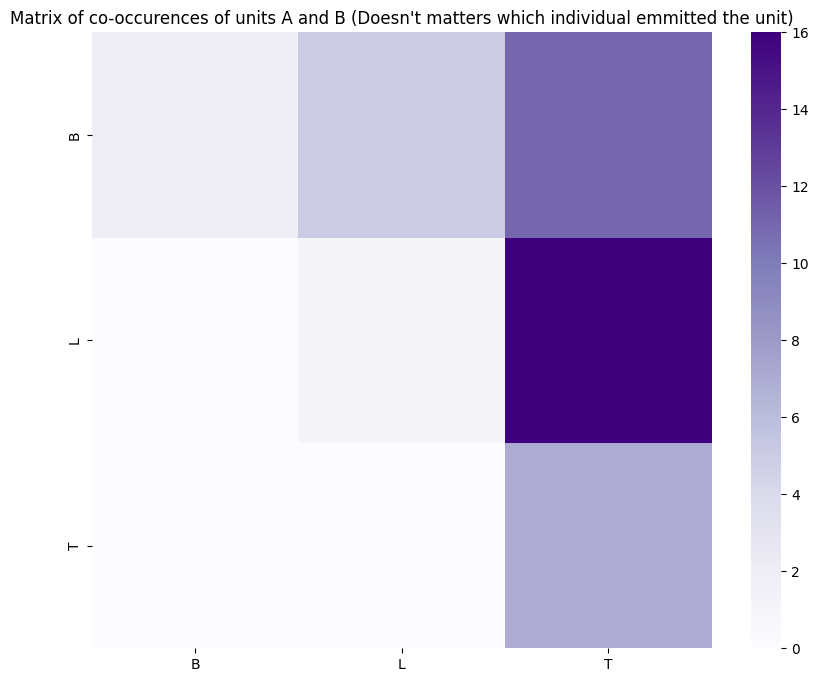

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(doesnt_matter_emitter_units_matrix, cmap='Purples')
plt.title("Matrix of co-occurences of units A and B (Doesn't matters which individual emmitted the unit)")
plt.show()


### Matters the emitter

In [130]:
matter_emitter_units_matrix = pd.DataFrame(index=sorted(units), columns=sorted(units))

# Fill the DataFrame with zeros (or any default value you want)
matter_emitter_units_matrix = matter_emitter_units_matrix.fillna(0)

for _, row in sequence_df.iterrows():
    tuples = row[2:].dropna()
    for i in range(len(tuples)):
        if not pd.isna(tuples[i]):
            emitter, unit = eval(tuples[i])

            # Increment the count in the matter_emitter_units_matrix for the corresponding unit pair 
            for other_unit in tuples[i + 1:]:
                if not pd.isna(other_unit):
                    other_emitter, other_unit = eval(other_unit)
                    if emitter != other_emitter:
                        sorted_position = sorted([unit, other_unit])
                        # print(sorted_position[0], sorted_position[1])
                        matter_emitter_units_matrix.at[sorted_position[0], sorted_position[1]] += 1
                        # matter_emitter_units_matrix.at[other_unit, unit] += 1  # Assuming co-occurrence is symmetric


In [131]:
# output = "Outputs/matrix_units__matter_emitter.xlsx"

# if os.path.exists(output):
#   os.remove(output)

# matter_emitter_units_matrix.to_excel(output)

In [132]:
overlap_csv.head()

,id,File name,0,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,20
0,1,DATA/Merged Interactions/01_Lomé.Nekketsu_23.0...,"[('p', 'B')]",[],"[('p', 'T')]","[('p', 'T'), ('f', 'T')]","[('p', 'T')]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,DATA/Merged Interactions/02_Lips.Pipo_25.01.23...,"[('f', 'B')]",[],"[('f', 'B')]",[],"[('f', 'T')]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,DATA/Merged Interactions/03_Bobo.Mako_26.01.23...,"[('p', 'L')]",[],"[('p', 'B')]",[],"[('p', 'T')]","[('p', 'T'), ('f', 'B')]","[('p', 'T')]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,DATA/Merged Interactions/04_Angèle.Violette_26...,"[('f', 'B')]",[],"[('f', 'L')]",[],"[('f', 'T')]",[],"[('f', 'T')]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,DATA/Merged Interactions/05_Bobo.Muse_30.01.23...,"[('p', 'L')]",[],"[('p', 'T')]",[],"[('p', 'T')]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


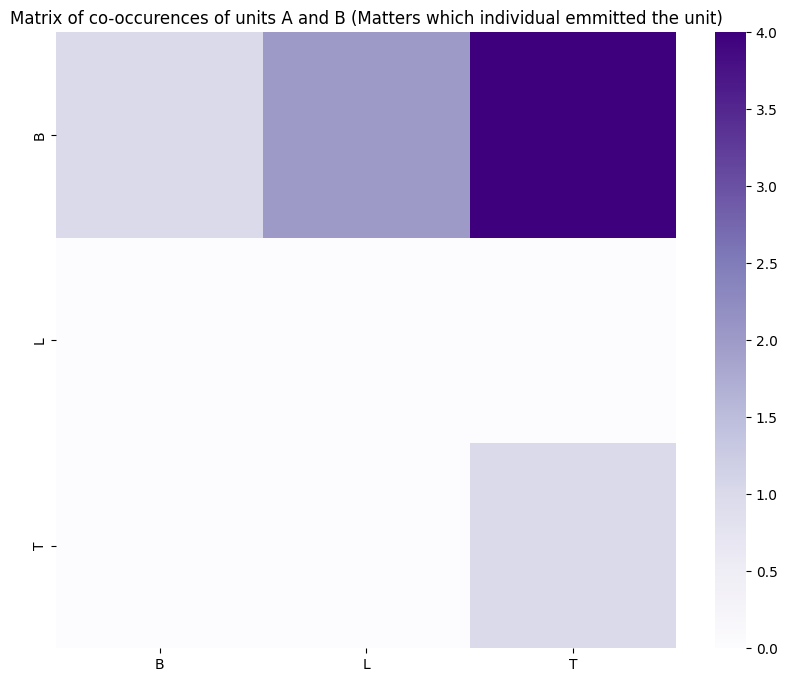

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(matter_emitter_units_matrix, cmap='Purples')
plt.title("Matrix of co-occurences of units A and B (Matters which individual emmitted the unit)")
plt.show()


In [134]:
# output = "Outputs/matrix_units_matters_emitter.xlsx"


# if os.path.exists(output):
#   os.remove(output)

# units_matrix.to_excel(output)

### Counting in Overlap

In [135]:
overlap_units_matrix = pd.DataFrame(index=sorted(units), columns=sorted(units))

# Fill the DataFrame with zeros (or any default value you want)
overlap_units_matrix = overlap_units_matrix.fillna(0)

for _, row in overlap_csv.iloc[:,2:].iterrows():
    tuples = row.dropna().values
    for i in range(len(tuples)):
        if not pd.isna(tuples[i]):
            units_list = eval(tuples[i])
            if len(units_list) > 1:  # Check if there's an overlap between two or more units
                for j in range(len(units_list)):
                    emitter, unit = units_list[j]
                    for k in range(j + 1, len(units_list)):
                        other_emitter, other_unit = units_list[k]
                        if emitter != other_emitter: # Comment this line to doesn't matter the emitter
                            # Sort the position ? it's not going to make it looks like a triangle
                            sorted_position = sorted([unit, other_unit])
                            overlap_units_matrix.at[sorted_position[0], sorted_position[1]] += 1
                            # overlap_units_matrix.at[unit, other_unit] += 1
                            # overlap_units_matrix.at[other_unit, unit] += 1  # Assuming co-occurrence is symmetric


In [136]:
overlap_units_matrix.head()

,B,L,T
B,0,0,2
L,0,0,0
T,0,0,1


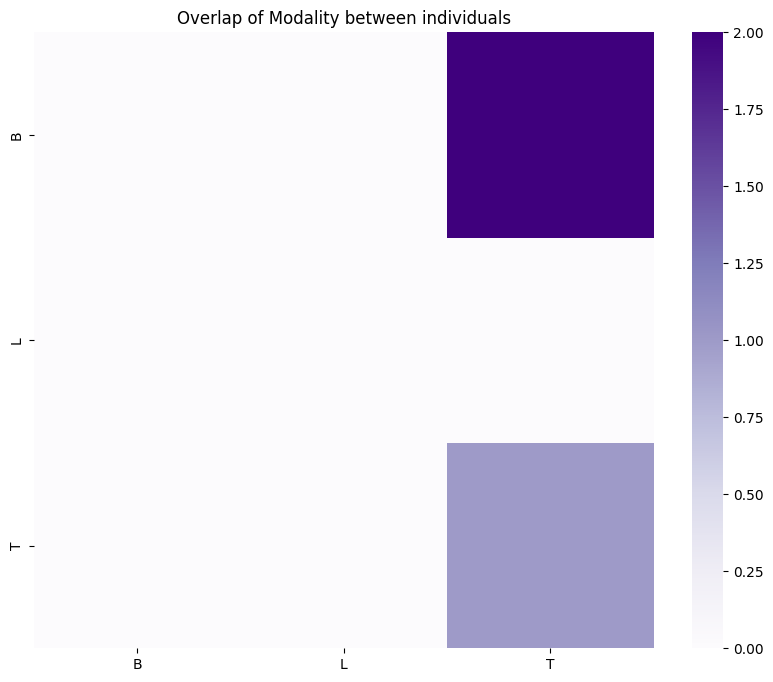

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_units_matrix, cmap="Purples")
plt.title("Overlap of "+category+" between individuals") # Overlap of modalities between individuals
plt.show()


# Count how many sequences an individual is

In [138]:
individual_appereances = dict()
for indiv in individuals:
  individual_appereances[indiv] = 0

for _, row in sequence_df.iterrows():
  focal = unidecode(row['File name'].split("_")[1].split(".")[0])
  individual = unidecode(row['File name'].split("_")[1].split(".")[1])
  individual_appereances[focal] += 1
  individual_appereances[individual] += 1

individual_appereances_df = pd.DataFrame(individual_appereances.items(), columns=['Individual', 'Number of sequences'])

In [139]:
# if os.path.exists("Outputs/individual_appereances.xlsx"):
#   os.remove("Outputs/individual_appereances.xlsx")

# individual_appereances_df.to_excel("Outputs/individual_appereances.xlsx", index=False)

# Symmetry Matrix

In [140]:
excel_file_path = "Outputs/"+category+"/Overlap_Details.xlsx"
overlap_details_df = overlap_counter_df.copy()
overlap_sequence = pd.read_excel("Outputs/"+category+"/Overlap_Sequence_"+ category +".xlsx")
sequence_symmetry_df = overlap_details_df[['id', 'File name', 'Focal', 'Partner']]

In [141]:
focal_count_alone_array = []
partner_count_alone_array = []
for i, row in overlap_sequence.iloc[:, 2:].iterrows():
    focal_count_alone = 0
    partner_count_alone = 0

    for elem in row:
        if not pd.isna(elem):
            elem = eval(unidecode(elem))
            
            if len(elem) != 0:
                if elem[0][0] == 'f' and len(elem) == 1:
                    focal_count_alone += 1
                elif elem[0][0] == 'p' and len(elem) == 1:
                    partner_count_alone += 1
                elif elem[0][0] == 'f' and all(item[0] != 'i' for item in elem[1:]):
                    focal_count_alone += 1
                elif elem[0][0] == 'p' and all(item[0] != 'f' for item in elem[1:]):
                    partner_count_alone += 1
                    
    focal_count_alone_array.append(focal_count_alone)
    partner_count_alone_array.append(partner_count_alone)
      
overlap_details_df['Focal count alone'] = focal_count_alone_array
overlap_details_df['Partner count alone'] = partner_count_alone_array
                  

In [142]:
# Per sequence
# Symmetry of Presence) [(number of states where A appears) - (number of states where B appears)] / [(number of states where A appears) + (number of states where B appears)]
# A is focal
# B is partner

for i, row in sequence_symmetry_df.iterrows():
    overlap_details_df_row = overlap_details_df[overlap_details_df['id'] == sequence_symmetry_df.at[i, 'id']]
    focal_count = overlap_details_df_row['Len States Focal'].values[0]
    partner_count = overlap_details_df_row['Len States Partner'].values[0]
    # overlap_count = overlap_details_df_row['Number Overlaps'].values[0]

    sequence_symmetry_df.loc[i, 'Symmetry of Presence'] = (focal_count - partner_count) / (focal_count + partner_count)


C:\Users\Arthur Duarte\AppData\Local\Temp\ipykernel_21100\2484057846.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequence_symmetry_df.loc[i, 'Symmetry of Presence'] = (focal_count - partner_count) / (focal_count + partner_count)


In [143]:
sequence_symmetry_df.head()

,id,File name,Focal,Partner,Symmetry of Presence
1,1,DATA/Merged Interactions/01_Lomé.Nekketsu_23.0...,Lomé,Nekketsu,-0.600000
2,2,DATA/Merged Interactions/02_Lips.Pipo_25.01.23...,Lips,Pipo,1.000000
3,3,DATA/Merged Interactions/03_Bobo.Mako_26.01.23...,Bobo,Mako,-0.666667
4,4,DATA/Merged Interactions/04_Angèle.Violette_26...,Angèle,Violette,1.000000
5,5,DATA/Merged Interactions/05_Bobo.Muse_30.01.23...,Bobo,Muse,-1.000000


In [144]:
# output_symmetry = "Outputs/Symmetry.xlsx"
# if os.path.exists(output_symmetry):
#   os.remove(output_symmetry)
# sequence_symmetry_df.to_excel(output_symmetry, index=False)

# Cleaning table

In [145]:
# Total units in the sequence total and per individual
sequence_details_df["Total Units"] = length_tokens_df["Number Total Tokens (repeated counted)"]
sequence_details_df["Total Focal Units"] = length_tokens_df["Focal Sequence Length"]
sequence_details_df["Total Partner Units"] = length_tokens_df["Partner Sequence Length"]

# Total unique units in the sequence total and per individual
sequence_details_df["Total Different Units"] = length_tokens_df["Number Both Tokens (repeated NOT counted)"]
sequence_details_df["Total Different Focal Units"] = length_tokens_df["Number Focal Tokens"]
sequence_details_df["Total Different Partner Units"] = length_tokens_df["Number Partner Tokens"]
sequence_details_df['Percentage of Overlap'] = overlap_counter_df['Percentage of Overlap']
sequence_details_df['Percentage of Focal States'] = overlap_counter_df['Percentage of Focal States']
sequence_details_df['Percentage of Partner States'] = overlap_counter_df['Percentage of Partner States']
sequence_details_df['Percentage of Intra-Focal Combinations'] = overlap_counter_df['Percentage of Intra Overlap Focal']
sequence_details_df['Percentage of Intra-Partner Combinations'] = overlap_counter_df['Percentage of intra Overlap Partner']
sequence_details_df['Symmetry of Presence'] = sequence_symmetry_df['Symmetry of Presence']

In [146]:
final_df = sequence_details_df.copy()

cols_to_drop = final_df.columns[final_df.columns.get_loc("File name")+1:final_df.columns.get_loc("Focal")]
final_df = final_df.drop(cols_to_drop, axis=1)
final_df = final_df.drop("File name", axis=1)
final_df.head(10)

,id,Focal,Partner,Sequence Length,Duration,Total Units,Total Focal Units,Total Partner Units,Total Different Units,Total Different Focal Units,Total Different Partner Units,Percentage of Overlap,Percentage of Focal States,Percentage of Partner States,Percentage of Intra-Focal Combinations,Percentage of Intra-Partner Combinations,Symmetry of Presence
1,1,Lomé,Nekketsu,5,10.888,3,1,2,2,1,2,0.200000,0.200000,0.800000,0.0,0.000000,-0.600000
2,2,Lips,Pipo,5,8.049,2,3,0,2,2,0,0.000000,0.600000,0.000000,0.0,0.000000,1.000000
3,3,Bobo,Mako,6,22.001,3,0,3,3,0,3,0.142857,0.142857,0.714286,0.0,0.000000,-0.666667
4,4,Angèle,Violette,6,13.559,3,3,0,3,3,0,0.000000,0.571429,0.000000,0.0,0.000000,1.000000
5,5,Bobo,Muse,5,14.975,2,0,3,2,0,2,0.000000,0.000000,0.600000,0.0,0.000000,-1.000000
6,6,Bobo,Muse,6,13.600,2,0,3,2,0,2,0.142857,0.142857,0.714286,0.0,0.000000,-0.666667
7,7,Fana,Petoulette,6,14.513,2,0,3,2,0,2,0.142857,0.000000,0.714286,0.0,0.142857,-1.000000
8,8,Petoulette,Pipo,5,12.393,2,3,0,2,2,0,0.000000,0.600000,0.000000,0.0,0.000000,1.000000
9,9,Nekketsu,Feya,5,11.619,2,3,0,2,2,0,0.600000,1.000000,0.000000,0.6,0.000000,1.000000
10,10,Fana,Mali,5,13.174,3,0,3,3,0,3,0.000000,0.000000,0.600000,0.0,0.000000,-1.000000


In [147]:
if os.path.exists("Outputs/"+category+"/Final_"+ category +".xlsx"):
    os.remove("Outputs/"+category+"/Final_"+ category +".xlsx")
final_df.to_excel("Outputs/"+category+"/Final_"+ category +".xlsx", index=False)